In [205]:
import os
import zipfile
import requests
import glob
import sys
import re
import time

import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions 
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import regularizers


%matplotlib inline

In [115]:
#Getting python version
print(sys.version)

3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]


In [116]:
#Getting tensorflow version
tf.__version__

'2.18.0'

In [117]:
#Checking that Tensorflow detects a GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [118]:
if gpus:
    try:
        # Restrict TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [119]:
# Check if the TF_GPU_ALLOCATOR environment variable is set
gpu_allocator = os.environ.get('TF_GPU_ALLOCATOR')

if gpu_allocator is None:
    print("Warning: The TF_GPU_ALLOCATOR environment variable is not set. This variable determines how TensorFlow manages GPU memory allocation."
          "Setting it to 'cuda_malloc_async' can improve performance on NVIDIA GPUs by reducing memory fragmentation during model training. "
          " Please consider setting the variable before running the model.")
else:
    print(f"TF_GPU_ALLOCATOR is set to: {gpu_allocator}")

TF_GPU_ALLOCATOR is set to: cuda_malloc_async


In [120]:
#set mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [121]:
#setting seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [122]:
#hide some warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [123]:
# Start timer to measure execution time
start_time = time.time()

# Download images to train our model

In [124]:
DATASET_DIR = '../dataset/fashion-product-images-small/myntradataset/'
ZIP_FILE_PATH = os.path.join(DATASET_DIR, 'fashion-product-images-small.zip')
DOWNLOAD_URL = 'https://www.kaggle.com/api/v1/datasets/download/paramaggarwal/fashion-product-images-small'

In [125]:
def is_empty_directory(directory):
    return not os.listdir(directory)

In [126]:
if is_empty_directory(DATASET_DIR):
    print("Empty dataset directory. Downloading ZIP File from Kaggle...")
    
    response = requests.get(DOWNLOAD_URL, allow_redirects=True)
    with open(ZIP_FILE_PATH, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Extract the ZIP file
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print("ZIP file extracted.")

    # Delete the ZIP file after extraction
    os.remove(ZIP_FILE_PATH)
else:
    print("The are images already downloaded. No need to download Zip file from Kaggle")

The are images already downloaded. No need to download Zip file from Kaggle


# EDA

In [127]:
#Load an image
image_path = f'{DATASET_DIR}/images/'
fullname = f'{image_path}/10009.jpg'
img=load_img(fullname, target_size=(224,224))

In [128]:
x=np.array(img)
x.shape

(224, 224, 3)

In [129]:
## Reading informacion about images
CSV_FILE_PATH = F'{DATASET_DIR}/styles.csv'

In [130]:
# Read the first few rows of the CSV to inspect its structure
preview_data = pd.read_csv(CSV_FILE_PATH, nrows=5)
print(preview_data.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2012  Casual             Peter England Men Party Blue Jeans  
2  2016  Casual                       Titan Women Silver Watch  
3  2011  Casual  Manchester United Men Solid Black Track Pants  
4  2012  Casual                          Puma Men Grey T-shirt  


In [131]:
#read dataset and skip some bad lines
columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'productDisplayName']
data = pd.read_csv(CSV_FILE_PATH,  usecols=columns, on_bad_lines='skip')
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt


In [132]:
type(data)

pandas.core.frame.DataFrame

In [133]:
#Adding a new column to dataset, with the file name
data['filename'] = data['id'].astype(str)+'.jpg'
data['filename'] = data['filename'].str.strip() 
data['filename'] = data['filename'].str.lower()  
data.head()

,id,gender,masterCategory,subCategory,articleType,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Puma Men Grey T-shirt,53759.jpg


In [134]:
IMAGES_DIR = f'{DATASET_DIR}/images'

In [135]:
# Checking for invalid filenames and getting information about images
invalid_filenames = []
image_sizes = []
all_images = []
for filename in data['filename']:
    file_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(file_path):
        invalid_filenames.append(filename)
    else:
        img = Image.open(file_path)
        image_sizes.append(img.size)
print("Invalid filenames:\n")
for invalid in invalid_filenames:
    print(invalid)


Invalid filenames:

39403.jpg
39410.jpg
39401.jpg
39425.jpg
12347.jpg


In [136]:
# Checking for images which information might not be on the dataset 
all_images = set(os.listdir(IMAGES_DIR))
dataset_filenames = set(data['filename'])
orphaned_images = all_images-dataset_filenames
if orphaned_images:
    print("\nOrphaned images (not in the dataset):\n")
    for img in orphaned_images:
        print(img)
else:
    print("\nAll images in the directory have corresponding entries in the dataset.")


All images in the directory have corresponding entries in the dataset.


In [137]:
#There are some missing images, we will just erase their information from the dataset
data_cleaned = data[~data['filename'].isin(invalid_filenames)]
print(f'Total images that will be used as input: {len(data_cleaned)}')

Total images that will be used as input: 44441


Displaying image corresponding to the article 'Turtle Check Men Navy Blue Shirt' of type 'Shirts'


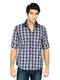

In [138]:
#Load one of the images to check is dimensions
sample_image_filename = data.iloc[0].filename
sample_image_fullname = f'{IMAGES_DIR}/{sample_image_filename}'
sample_image_displayName =  data.iloc[0].productDisplayName
sample_image_articleType = data.iloc[0].articleType
img = load_img(sample_image_fullname)

print(f'Displaying image corresponding to the article \'{sample_image_displayName}\' of type \'{sample_image_articleType}\'')
img

In [139]:
x=np.array(img)
x.shape

(80, 60, 3)

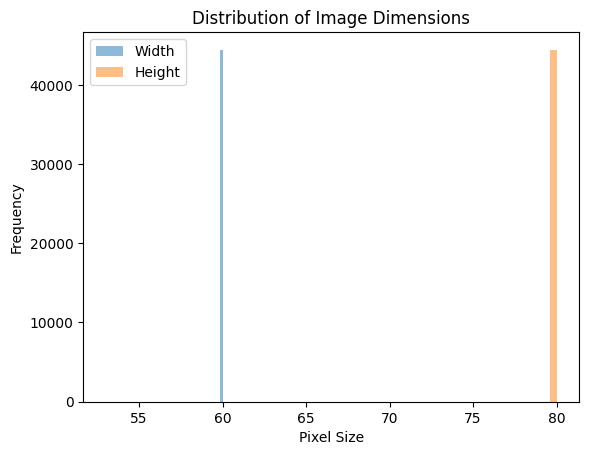

In [140]:
#Analyzing distribution of image dimensions
width, height = zip(*image_sizes)
plt.hist(width, bins=50, alpha=0.5, label='Width')
plt.hist(height, bins=50, alpha=0.5, label='Height')
plt.xlabel('Pixel Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

In [141]:
# Conclusion: All the images have a size of 60x80

In [142]:
#Analyzing how many articles are there per class
sub_category_counts =data.groupby('articleType').size().reset_index(name='count')
sub_category_counts.sort_values(by='count', ascending=True)

,articleType,count
10,Body Wash and Scrub,1
26,Cushion Covers,1
54,Ipad,1
46,Hair Accessory,1
106,Shoe Laces,1
...,...,...
112,Sports Shoes,2036
140,Watches,2542
19,Casual Shoes,2846
104,Shirts,3217


In [172]:
# Filter the article types to keep only those with more than 3 samples (we need 1 sample in each dataframe: train, val and test)
valid_article_types = sub_category_counts[sub_category_counts['count'] >= 3]['articleType']
data_cleaned = data_cleaned[data_cleaned['articleType'].isin(valid_article_types)]

In [173]:
classes = data_cleaned['articleType'].nunique()
classes

132

In [174]:
#split the data into training, validation and test datasets
train_df, val_df = train_test_split(data_cleaned, test_size=0.2, random_state=42, stratify=data_cleaned['articleType'])

In [175]:
# defining a target size for images
TARGET_SIZE = (96, 96)
#defining a batch size
BATCH_SIZE=32
#defining a max queue size (count of batches preloaded in the queue while the model is training)
MAX_QUEUE_SIZE=10

In [176]:
# calculating how many workers threads for loading data
##warning: it is not certain that these parameters are being used by the ImageDataGenerator
num_cores = os.cpu_count()
workers = int(num_cores / 2)
use_multiprocessing=False
if workers>1:
   use_multiprocessing=True

In [177]:
#Read images by using ImageDataGenerator (we will use the articleType as our class)
train_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 35541 validated image filenames belonging to 132 classes.


In [178]:
val_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_image_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE    
)

Found 8886 validated image filenames belonging to 132 classes.


In [179]:
class_indices= train_gen.class_indices
class_indices

{'Accessory Gift Set': 0,
 'Baby Dolls': 1,
 'Backpacks': 2,
 'Bangle': 3,
 'Basketballs': 4,
 'Bath Robe': 5,
 'Beauty Accessory': 6,
 'Belts': 7,
 'Blazers': 8,
 'Body Lotion': 9,
 'Booties': 10,
 'Boxers': 11,
 'Bra': 12,
 'Bracelet': 13,
 'Briefs': 14,
 'Camisoles': 15,
 'Capris': 16,
 'Caps': 17,
 'Casual Shoes': 18,
 'Churidar': 19,
 'Clothing Set': 20,
 'Clutches': 21,
 'Compact': 22,
 'Concealer': 23,
 'Cufflinks': 24,
 'Deodorant': 25,
 'Dresses': 26,
 'Duffel Bag': 27,
 'Dupatta': 28,
 'Earrings': 29,
 'Eye Cream': 30,
 'Eyeshadow': 31,
 'Face Moisturisers': 32,
 'Face Scrub and Exfoliator': 33,
 'Face Wash and Cleanser': 34,
 'Flats': 35,
 'Flip Flops': 36,
 'Footballs': 37,
 'Formal Shoes': 38,
 'Foundation and Primer': 39,
 'Fragrance Gift Set': 40,
 'Free Gifts': 41,
 'Gloves': 42,
 'Hair Colour': 43,
 'Handbags': 44,
 'Hat': 45,
 'Headband': 46,
 'Heels': 47,
 'Highlighter and Blush': 48,
 'Innerwear Vests': 49,
 'Jackets': 50,
 'Jeans': 51,
 'Jeggings': 52,
 'Jewellery 

In [180]:
count_classes = len(class_indices)
print (f'Category count:  {count_classes}')

Category count:  132


In [181]:
#check size of images and batches
batch_images, batch_labels = next(train_gen)  
print("Batch shape for training:", batch_images.shape) 
print("Shape of training labels:", batch_labels.shape) 

batch_images, batch_labels = next(val_gen)  
print("Batch shape for validation:", batch_images.shape) 
print("Shape of validation labels:", batch_labels.shape) 

Batch shape for training: (32, 96, 96, 3)
Shape of training labels: (32, 132)
Batch shape for validation: (32, 96, 96, 3)
Shape of validation labels: (32, 132)


In [38]:
# Conclusion: There are some categories for which we have very few samples

# Transfering learning

In [83]:
# Initialize a dictionary to store results for each model
model_results = {}

## Create Model v1 with MobileNetV2

In [206]:
def make_model_Mobile_v1(learning_rate=0.01):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    
    #dense layer
    outputs = keras.layers.Dense(count_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(vectors)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [40]:
model = make_model_Mobile_v1()

I0000 00:00:1735359735.460180   87656 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1735359735.463476   87656 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [41]:
#train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10


I0000 00:00:1735359739.554030   87749 service.cc:148] XLA service 0x7f4e30004b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735359739.554065   87749 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-12-27 23:22:19.613662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735359740.034903   87749 cuda_dnn.cc:529] Loaded cuDNN version 90600


  13/1112 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2330 - loss: 5.6448      

I0000 00:00:1735359742.698074   87749 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1112/1112 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.6824 - loss: 2.5281 - val_accuracy: 0.7687 - val_loss: 2.2789
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.8176 - loss: 1.4182 - val_accuracy: 0.7874 - val_loss: 2.4606
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8493 - loss: 1.1793 - val_accuracy: 0.7858 - val_loss: 2.9020
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8670 - loss: 0.9730 - val_accuracy: 0.7912 - val_loss: 3.2435
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8785 - loss: 0.9433 - val_accuracy: 0.8000 - val_loss: 3.1238
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.8912 - loss: 0.8637 - val_accuracy: 0.7942 - val_loss: 3.5834
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.8972 - loss: 0.8094 - val_accuracy: 0.7966 - val_loss: 3.8632
Epoch 8/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9011 - loss: 0.76

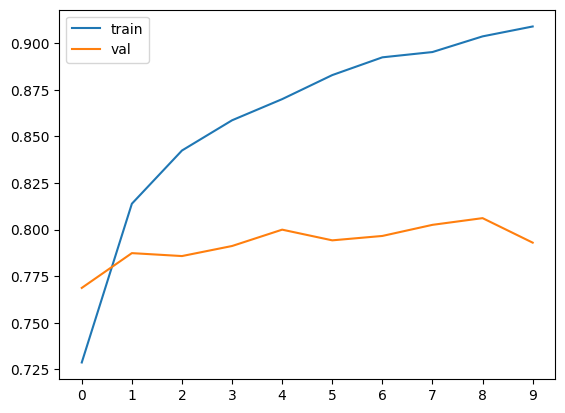

In [42]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [43]:
#Conclusion after training: the model is overfitting

In [44]:
#run prediction for the image used as example
img = load_img(sample_image_fullname, target_size=TARGET_SIZE)
x=np.array(img)
x = preprocess_input(x)
X = np.array([x])
preds = model.predict(X)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.4012985e-45,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0219767e-36, 0.0000000e+00, 6.3618950e-43, 0.0000000e+00,
        1.4012985e-45, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.1657132e-44,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 9.3783467e-37, 8.5479206e-44,
        1.8418667e-41, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 6.3619651e-40, 0.0000000e+00, 2.9918565e-37,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

In [45]:
# Get the index of the highest probability
predicted_index = np.argmax(preds, axis=1)[0] 

class_labels = {v: k for k, v in train_gen.class_indices.items()}
predicted_class_name = class_labels[predicted_index]

# Print the result
print(f"The predicted class for the sample image: '{sample_image_displayName}', "
      f"was '{predicted_class_name}' with a probability of: {preds[0][predicted_index]:.4f}")

The predicted class for the sample image: 'Turtle Check Men Navy Blue Shirt', was 'Shirts' with a probability of: 1.0000


### Adjusting learning rate for Model version 1

In [46]:
scores={}
print("Training with different learning rates:\n")
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model_Mobile_v1(learning_rate=lr)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen)
    scores[lr]= history.history

    print()
    print()

Training with different learning rates:

0.0001
Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.4274 - loss: 2.5159 - val_accuracy: 0.7246 - val_loss: 0.9862
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.7515 - loss: 0.8552 - val_accuracy: 0.7715 - val_loss: 0.7720
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.7969 - loss: 0.6637 - val_accuracy: 0.7937 - val_loss: 0.6911
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8226 - loss: 0.5705 - val_accuracy: 0.8047 - val_loss: 0.6423
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.8411 - loss: 0.5018 - val_accuracy: 0.8118 - val_loss: 0.6176
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8575 - loss: 0.4518 - val_accuracy: 0.8168 - val_loss: 0.5969
Epoch 7/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.8687 - loss: 0.4207 - val_accuracy: 0.8220 - val_loss: 0.5801
Epoch 8/10
1112/1112 ━━━━━━━

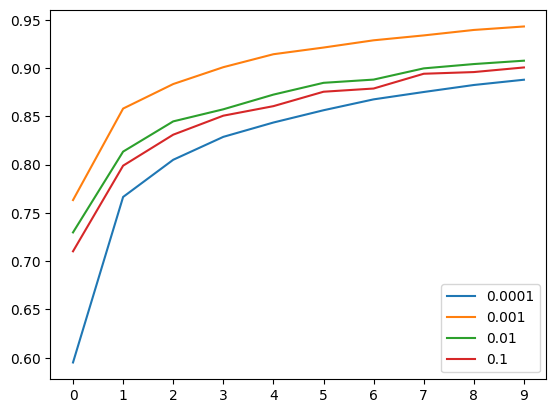

In [47]:
#Plotting the train accuracy
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

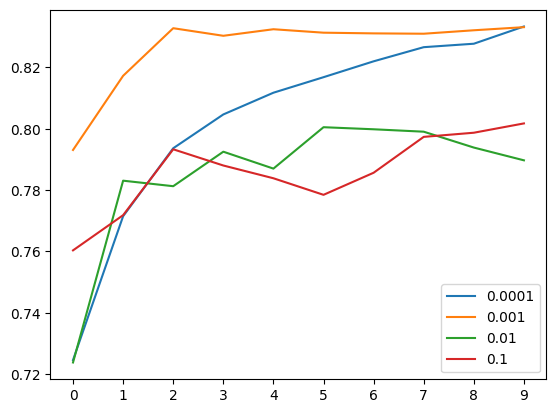

In [48]:
#Plotting the validation accuracy
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=lr)

plt.xticks(np.arange(10))
plt.legend()

In [39]:
#Conclusion: The learning rate 0.001 is the best learning rate
best_learning_rate=0.001

In [47]:
MODELS_DIR = '../models'

In [68]:
#Defining function to delete any previously saved files
def delete_previous_checkpoint_files(filename_pattern):
    # Compile the regex pattern
    regex = re.compile(filename_pattern)
    
    # List all files in the specified directory
    files = os.listdir(MODELS_DIR)

    # Filter files matching the regex pattern
    matching_files = [f for f in files if regex.match(f)]
    
    # Check if there are matching files
    if not matching_files:
        print("No matching files found for deletion.")
        return 

    # Iterate through the matching files and delete them
    for checkpoint_file in matching_files:
        full_file_path = os.path.join(MODELS_DIR, checkpoint_file)
        try:
            os.remove(full_file_path)  # Attempt to delete the file
            print(f"Deleted checkpoint file: {checkpoint_file}")
        except Exception as e:
            print(f"Error deleting file {full_file_path}: {e}")

In [69]:
#Define class for a custom checkpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = 0.0
        self.best_model_file = ""

    def on_epoch_end(self, epoch, logs=None):
        # Call the parent class's method to save the model if needed
        super().on_epoch_end(epoch, logs)

        # Get the current validation accuracy
        current_val_accuracy = logs.get('val_accuracy')
        
        if current_val_accuracy > self.best_accuracy:
            # Update best values
            self.best_accuracy = current_val_accuracy
            self.best_model_file = self.filepath.format(epoch=epoch + 1, **logs)

In [70]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v1.*\.keras')
print(f'\nTraining the model with learning rate {best_learning_rate}\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = make_model_Mobile_v1(learning_rate=best_learning_rate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v1_01_0.810.keras
Deleted checkpoint file: Mobile_v1_02_0.826.keras
Training the model with learning rate 0.001

Epoch 1/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6863 - loss: 1.2415 - val_accuracy: 0.8140 - val_loss: 0.6536
Epoch 2/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8617 - loss: 0.4257 - val_accuracy: 0.8246 - val_loss: 0.6041
Epoch 3/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.8903 - loss: 0.3279 - val_accuracy: 0.8303 - val_loss: 0.6027
Epoch 4/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9045 - loss: 0.2764 - val_accuracy: 0.8318 - val_loss: 0.6222
Epoch 5/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.9214 - loss: 0.2331 - val_accuracy: 0.8379 - val_loss: 0.6110
Epoch 6/10
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9276 - loss: 0.2119 - val_accuracy: 0.8310 - val_loss: 0.6406
Epoch 7/10

In [72]:
model_results['mobile_v1'] = {
    'accuracy': round(custom_checkpoint.best_accuracy, 4),
    'filename': custom_checkpoint.best_model_file
}
rint(f"Best Validation Accuracy for 'Mobile version 1' model: {model_results['mobile_v1']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v1']['filename']}")

Best Validation Accuracy: {0.8379}
Saved Model File: ../models/Mobile_v1_05_0.838.keras


## Create Model version 2 by adding another inner layer

In [73]:
def make_model_Mobile_v2(learning_rate=0.01, inner_layer_units=1420):
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(inner)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

### Find the best inner layer size

In [74]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v2_size.*\.keras')
print(f'Training the model with different sizes for the inner layer \n')

scores={}
for size in [count_classes*3, count_classes*5, count_classes*10, count_classes*20]:
    print(f'Fitting model for size {size}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v2_size{size}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v2(learning_rate=best_learning_rate, inner_layer_units=size)
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[size] = history.history
    print()
    print()

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v2_size426_03_0.821.keras
Deleted checkpoint file: Mobile_v2_size2840_03_0.815.keras
Deleted checkpoint file: Mobile_v2_size2840_09_0.833.keras
Deleted checkpoint file: Mobile_v2_size710_07_0.833.keras
Deleted checkpoint file: Mobile_v2_size426_09_0.832.keras
Deleted checkpoint file: Mobile_v2_06_0.831.keras
Deleted checkpoint file: Mobile_v2_size710_02_0.824.keras
Deleted checkpoint file: Mobile_v2_size2840_03_0.819.keras
Deleted checkpoint file: Mobile_v2_size1420_02_0.817.keras
Deleted checkpoint file: Mobile_v2_size426_04_0.824.keras
Deleted checkpoint file: Mobile_v2_size426_01_0.809.keras
Deleted checkpoint file: Mobile_v2_size2840_01_0.804.keras
Deleted checkpoint file: Mobile_v2_size2840_02_0.810.keras
Deleted checkpoint file: Mobile_v2_size710_03_0.828.keras
Deleted checkpoint file: Mobile_v2_size426_06_0.826.keras
Deleted checkpoint file: Mobile_v2_07_0.834.keras
Deleted checkpoint file: Mobi

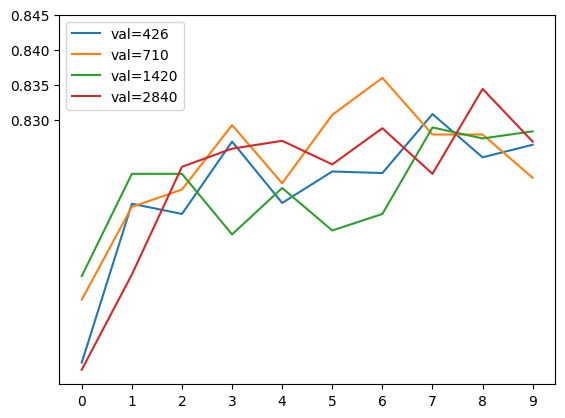

In [75]:
#Plotting the results
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.yticks([0.83, 0.835, 0.84, 0.845])
plt.legend()

In [ ]:
#Conclusion: the inner layers with size 710 and 2840 give the best accuracies, 
# but not significantly more than the model with just one dense layer

In [78]:
#Building a resume with the results
best_models_info = {}

for size in scores.keys():
    best_val_accuracy = max(scores[size]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v2_size{size}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[size] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  # Get the first matching file
        }
    else:
        print(f"No checkpoint files found for size {size} with accuracy {best_val_accuracy:.3f}")

for size, info in best_models_info.items():
    print(f"Best model for inner layer size {size}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")        

Best model for inner layer size 426:
Best Validation Accuracy: 0.831
Checkpoint file: ../models/Mobile_v2_size426_08_0.831.keras
Best model for inner layer size 710:
Best Validation Accuracy: 0.836
Checkpoint file: ../models/Mobile_v2_size710_07_0.836.keras
Best model for inner layer size 1420:
Best Validation Accuracy: 0.829
Checkpoint file: ../models/Mobile_v2_size1420_08_0.829.keras
Best model for inner layer size 2840:
Best Validation Accuracy: 0.834
Checkpoint file: ../models/Mobile_v2_size2840_09_0.834.keras


In [84]:
#I will go with an inner layer of 710 units
model_results['mobile_v2'] = {
        'accuracy': round(best_models_info[710]['best_accuracy'], 4),
        'filename': best_models_info[710]['checkpoint_file']
    }
print(f"Best Validation Accuracy for 'Mobile version 2' model: {model_results['mobile_v2']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v2']['filename']}")

Best Validation Accuracy for 'Mobile version 2' model: 0.836
Saved Model File: ../models/Mobile_v2_size710_07_0.836.keras


### Creating Mobile Model version 3 by adding a dropout layer

In [92]:
def make_model_Mobile_v3(droprate=0.5):

    learning_rate=0.01
    inner_layer_units = 710
    
    #clear any unused session
    tf.keras.backend.clear_session()

    #creating a base model
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
    base_model =MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    # create a model from the base model
    base_model.trainable=False
    inputs = keras.Input(shape=input_shape)
    base = base_model(inputs, training=False)
    
    #pooling layer
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    #dense layer 1
    inner = keras.layers.Dense(inner_layer_units, activation='relu')(vectors)

    #dropout for inner layer 1
    drop = keras.layers.Dropout(droprate)(inner)
    
    #dense layer 2
    outputs = keras.layers.Dense(units=count_classes, activation='softmax')(drop)

    #final model
    model = keras.Model(inputs, outputs)

    #compile de model
    optimizer =keras.optimizers.Adam(learning_rate=learning_rate)
    loss=keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [103]:
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v3_droprate.*\.keras')
print(f'Training the model with different dropout rates for the inner layer \n')

#droprates = [0.0, 0.01, 0.03, 0.05, 0.1]
droprates = [0.0, 0.01]
scores={}
#I initially experimented with a variety of dropout rates during the training and 30 epochs
#but the accuracy wasnt higher and it took too long, so I narrowed it down to fewer options in the notebook
for droprate in droprates:
    print(f'Fitting model for drop rate {droprate}')
    custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v3_droprate{droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')    
    model = make_model_Mobile_v3(droprate)
    history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks = [custom_checkpoint])
    scores[droprate] = history.history
    print()
    print()

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v3_droprate0.0_30_0.766.keras
Deleted checkpoint file: Mobile_v3_droprate0.2_04_0.720.keras
Deleted checkpoint file: Mobile_v3_droprate0.03_04_0.756.keras
Deleted checkpoint file: Mobile_v3_droprate0.01_05_0.741.keras
Deleted checkpoint file: Mobile_v3_droprate0.05_01_0.716.keras
Deleted checkpoint file: Mobile_v3_droprate0.0_02_0.732.keras
Deleted checkpoint file: Mobile_v3_droprate0.2_15_0.732.keras
Deleted checkpoint file: Mobile_v3_droprate0.03_01_0.709.keras
Deleted checkpoint file: Mobile_v3_droprate0.0_11_0.764.keras
Deleted checkpoint file: Mobile_v3_droprate0.2_22_0.733.keras
Deleted checkpoint file: Mobile_v3_droprate0.0_08_0.757.keras
Deleted checkpoint file: Mobile_v3_droprate0.1_01_0.692.keras
Deleted checkpoint file: Mobile_v3_droprate0.05_02_0.742.keras
Deleted checkpoint file: Mobile_v3_droprate0.0_05_0.756.keras
Deleted checkpoint file: Mobile_v3_droprate0.2_01_0.705.keras
Deleted chec

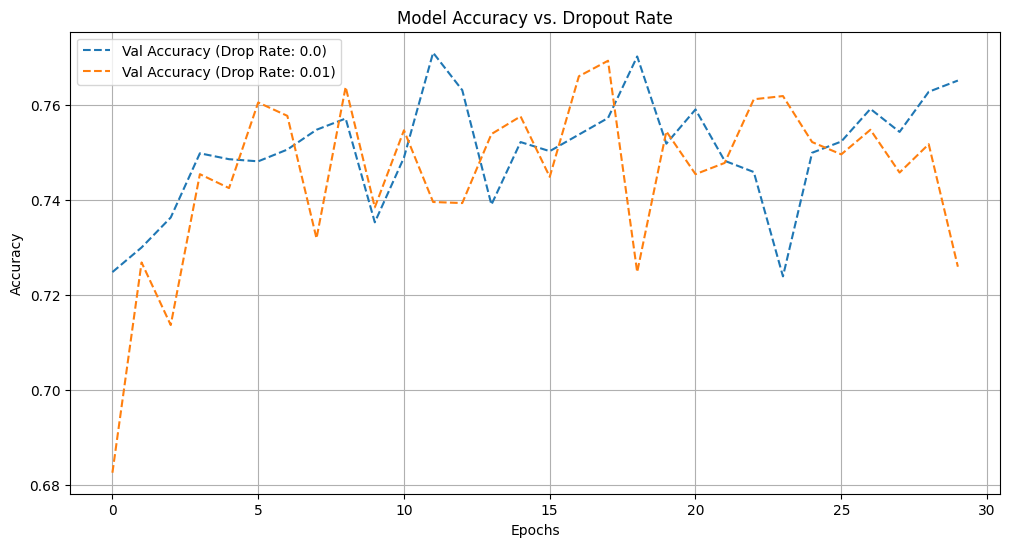

In [105]:
# Plotting the results
plt.figure(figsize=(12, 6))

for droprate in [0.0, 0.01]:
    plt.plot(scores[droprate]['val_accuracy'], label=f'Val Accuracy (Drop Rate: {droprate})', linestyle='--')

plt.title('Model Accuracy vs. Dropout Rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [107]:
#Building a summary with the results
best_models_info = {}

for droprate in scores.keys():
    best_val_accuracy = max(scores[droprate]['val_accuracy'])
    
    checkpoint_filename_pattern = f'Mobile_v3_droprate{droprate}_*_{best_val_accuracy:.3f}.keras'
    checkpoint_files = glob.glob(os.path.join(MODELS_DIR, checkpoint_filename_pattern))
    
    if checkpoint_files:
        best_models_info[droprate] = {
            'best_accuracy': best_val_accuracy,
            'checkpoint_file': checkpoint_files[0]  # Get the first matching file
        }
    else:
        print(f"No checkpoint files found for drop rate {droprate} with accuracy {best_val_accuracy:.3f}")

for droprate, info in best_models_info.items():
    print(f"Best model for drop rate {droprate}:")
    print(f"Best Validation Accuracy: {info['best_accuracy']:.3f}")
    print(f"Checkpoint file: {info['checkpoint_file']}")   

Best model for drop rate 0.0:
Best Validation Accuracy: 0.771
Checkpoint file: ../models/Mobile_v3_droprate0.0_12_0.771.keras
Best model for drop rate 0.01:
Best Validation Accuracy: 0.769
Checkpoint file: ../models/Mobile_v3_droprate0.01_18_0.769.keras


In [108]:
## Conclusion: there is not a better accuracy by having a version of the model with a dropout layer

#In case of using this version of the model, I would go with a drop rate of 0.01
model_results['mobile_v3'] = {
        'accuracy': round(best_models_info[0.01]['best_accuracy'], 4),
        'filename': best_models_info[0.01]['checkpoint_file']
    }
print(f"Best Validation Accuracy for 'Mobile version 3' model: {model_results['mobile_v3']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v3']['filename']}")


Best Validation Accuracy for 'Mobile version 3' model: 0.7692
Saved Model File: ../models/Mobile_v3_droprate0.01_18_0.769.keras


### Using the model Mobile version 1 trained with augmentation

In [200]:
#declare a new generator for the train dataset
#the generator for the validation dataset is kept as before, the augmentations are applied to the training dataset only
#(the parameters set here were selected after some experimentation)
train_gen = image_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_DIR, 
    x_col='filename',  
    y_col='articleType', 
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,                
    workers = workers,
    use_multiprocessing=use_multiprocessing,
    max_queue_size=MAX_QUEUE_SIZE
)

Found 35541 validated image filenames belonging to 132 classes.


In [201]:
#check size of images and batches
batch_images, batch_labels = next(train_gen)  
print("Batch shape for training:", batch_images.shape) 
print("Shape of training labels:", batch_labels.shape) 

batch_images, batch_labels = next(val_gen)  
print("Batch shape for validation:", batch_images.shape) 
print("Shape of validation labels:", batch_labels.shape) 

Batch shape for training: (32, 96, 96, 3)
Shape of training labels: (32, 132)
Batch shape for validation: (32, 96, 96, 3)
Shape of validation labels: (32, 132)


In [207]:
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v1_aug.*\.keras')
learning_rate=best_learning_rate
print(f'\nTraining the model with augmentation and learning rate {learning_rate}\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_aug_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = make_model_Mobile_v1(learning_rate=learning_rate)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)


Deleting files previously saved to output directory

No matching files found for deletion.

Training the model with augmentation and learning rate 0.001

Epoch 1/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.6769 - loss: 1.4864 - val_accuracy: 0.8141 - val_loss: 0.7757
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8427 - loss: 0.6664 - val_accuracy: 0.8251 - val_loss: 0.7278
Epoch 3/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8644 - loss: 0.5803 - val_accuracy: 0.8296 - val_loss: 0.7185
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8732 - loss: 0.5544 - val_accuracy: 0.8309 - val_loss: 0.7258
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8751 - loss: 0.5498 - val_accuracy: 0.8233 - val_loss: 0.7517
Epoch 6/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.8786 - loss: 0.5337 - val_accuracy: 0.8234 - val_loss: 0.7354
Epoch 7/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/ste

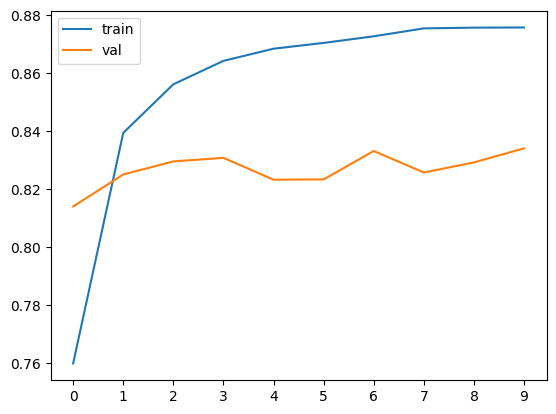

In [208]:
#Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [ ]:
## Conclusion: by using augmentation, the model is not overfitting

In [ ]:
#Training the model for 20 epochs, to compare results
#deleting any previous files
print('Deleting files previously saved to output directory\n')
delete_previous_checkpoint_files(r'Mobile_v1_aug.*\.keras')
learning_rate=best_learning_rate
print(f'\nTraining the model with augmentation and learning rate {learning_rate}\n')
#definining a checkpoint to save the model when the accuracy is the max accuracy
custom_checkpoint = CustomModelCheckpoint(f'{MODELS_DIR}/Mobile_v1_aug_{{epoch:02d}}_{{val_accuracy:.3f}}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max')

model = make_model_Mobile_v1(learning_rate=learning_rate)
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks = [custom_checkpoint]
)

Deleting files previously saved to output directory

Deleted checkpoint file: Mobile_v1_aug_10_0.834.keras
Deleted checkpoint file: Mobile_v1_aug_04_0.831.keras
Deleted checkpoint file: Mobile_v1_aug_01_0.814.keras
Deleted checkpoint file: Mobile_v1_aug_03_0.830.keras
Deleted checkpoint file: Mobile_v1_aug_02_0.825.keras
Deleted checkpoint file: Mobile_v1_aug_07_0.833.keras

Training the model with augmentation and learning rate 0.001

Epoch 1/20
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6808 - loss: 1.4588 - val_accuracy: 0.8214 - val_loss: 0.7753
Epoch 2/20
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8459 - loss: 0.6574 - val_accuracy: 0.8198 - val_loss: 0.7396
Epoch 3/20
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8632 - loss: 0.5820 - val_accuracy: 0.8296 - val_loss: 0.7265
Epoch 4/20
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.8739 - loss: 0.5557 - val_accuracy: 0.8266 - val_loss: 0.7188
Epoch 5/20
1111/1111 ━━━━━━━━━━━

In [191]:
model_results['mobile_v1_with_augmentation'] = {
    'accuracy': round(custom_checkpoint.best_accuracy, 4),
    'filename': custom_checkpoint.best_model_file
}
print(f"Best Validation Accuracy for 'Mobile version 1 with Augmentation' model: {model_results['mobile_v1_with_augmentation']['accuracy']}")
print(f"Saved Model File: {model_results['mobile_v1_with_augmentation']['filename']}")

Best Validation Accuracy for 'Mobile version 1 with Augmentation' model: 0.8426
Saved Model File: ../models/Mobile_v1_aug_08_0.843.keras
